# Experiment with Adam optimizer

Variations of adam optimizer are used for image classfication on CIFAR-10 dataset. Resnet is used for the classification task and implemented in pytorch.

# Data

In [3]:
import os
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime

import torch
from torchvision import models
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

warnings.filterwarnings("ignore")
plt.ion()

In [4]:
from torchvision import transforms
BATCH_SIZE = 32

## transformations
transform_train = transforms.Compose([transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      transforms.RandomRotation(10),     #Rotates the image to a specified angel
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
                                      ])
 
transform_test = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

train_dset = torchvision.datasets.CIFAR10('cifar10_pytorch', train=True,
                                                  transform=transform_train, download=True)
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_dset = torchvision.datasets.CIFAR10('cifar10_pytorch', train=False,
                                                  transform=transform_test, download=True)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar10_pytorch/cifar-10-python.tar.gz to cifar10_pytorch
Files already downloaded and verified


# Model

In [39]:
from torchsummary import summary

class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv7 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        self.conv8 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn8 = nn.BatchNorm2d(256)
        self.conv9 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn9 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv10 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn10 = nn.BatchNorm2d(512)
        self.conv11 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn11 = nn.BatchNorm2d(512)
        self.conv12 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn12 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(2 * 2 * 512, 200)
        self.fc2 = nn.Linear(200, 10)
        

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        res = x
        x = F.relu(self.bn3(self.conv3(x)))
        x = res + x
        x = self.pool1(x)

        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        res = x
        x = F.relu(self.bn6(self.conv6(x)))
        x = res + x
        x = self.pool2(x)

        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        res = x
        x = F.relu(self.bn9(self.conv9(x)))
        x = res + x
        x = self.pool3(x)

        x = F.relu(self.bn10(self.conv10(x)))
        x = F.relu(self.bn11(self.conv11(x)))
        res = x
        x = F.relu(self.bn12(self.conv12(x)))
        x = res + x
        x = self.pool4(x)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

summary(ResNet().cuda(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,928
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,928
       BatchNorm2d-6           [-1, 64, 32, 32]             128
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,584
      BatchNorm2d-11          [-1, 128, 16, 16]             256
           Conv2d-12          [-1, 128, 16, 16]         147,584
      BatchNorm2d-13          [-1, 128, 16, 16]             256
        MaxPool2d-14            [-1, 12

In [6]:
def train(epochs, model, criterion, optimizer, train_loader, test_loader):
    train_epoch_loss, test_epoch_loss, train_epoch_acc, test_epoch_acc = [], [], [], []
    for epoch in range(epochs):
        train_acc, train_loss = train_epoch(model, criterion, optimizer, train_loader)
        test_acc, test_loss = test(model, criterion, test_loader)
        train_epoch_acc.append(train_acc)
        test_epoch_acc.append(test_acc)
        train_epoch_loss.append(train_loss)
        test_epoch_loss.append(test_loss)
        print('Epoch {:03d}/{:03d}, Train Accuracy {:.2f}% || Test Accuracy {:.2f}% || Train Loss {:.2f} || Test Loss {:.2f}'.format(epoch, epochs, train_acc*100, test_acc*100, train_loss, test_loss))
    return train_epoch_loss, test_epoch_loss, train_epoch_acc, test_epoch_acc
    
def train_epoch(model, criterion, optimizer, loader):
    total_correct = 0.
    total_samples = 0.
    total_loss = 0.
    
    for batch_idx, (data, target) in enumerate(loader):
        if torch.cuda.is_available():
          data, target = data.cuda(), target.cuda()            
        output = model(data)
        loss = criterion(output, target)
        total_correct += (torch.max(output, 1)[1].view(target.size()).data == target.data).sum()
        total_samples += target.shape[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    total_loss /= (batch_idx + 1)
    return total_correct/total_samples, total_loss
    
def test(model, criterion, loader):
    total_correct = 0.
    total_samples = 0.
    total_loss = 0.0
    model.eval()
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(loader):
            if torch.cuda.is_available():
              data, target = data.cuda(), target.cuda()            
            output = model(data)
            loss = criterion(output, target)
            total_correct += torch.eq(torch.max(output, 1)[1].view(target.size()).data, target.data).sum()
            total_samples += target.shape[0]
            total_loss += loss.item()
        total_loss /= (batch_idx + 1)
    return total_correct/total_samples, total_loss

# Optimizers

### Adam
Standard Adam algorithm is described below: \
$\eta$: Step size \
$\beta_1, \beta_2 \in [0, 1)$: Exponential decay rates for the moment estimates \
$L(\phi)$: Loss function with parameters $\phi$ \
$t$: Current step \
$g_t \gets \nabla_{\phi}f_t(\phi_{t-1})$  (gradients with respect to parameters $\phi$)\
$m_t \gets \frac{\beta_1 m_{t−1} + (1 − \beta_1) g_t}{1-\beta_1^t}$ (first moment)\
$v_t \gets \frac{\beta_2 v_{t−1} + (1 − \beta_2) g_t^2}{1 - \beta_2^t}$ (second moment) \

$\phi_{t+1} \gets \phi_t - \frac{\eta m_t}{\sqrt{v_t} + ϵ} $ \


In [5]:
# Adam optimizer
import math
from torch.optim import Optimizer

class Adam(Optimizer):

    def __init__(self, params, lr=1e-2, betas=(0.9, 0.999), epsilon=1e-8,
            weight_decay=0):
        defaults = dict(lr=lr, betas=betas, epsilon=epsilon,
                weight_decay=weight_decay)
        super(Adam, self).__init__(params, defaults)

    def step(self, forward_closure=None):
        loss = None
        if forward_closure is not None:
            loss = self._forward_backward(forward_closure)

        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad
                state = self.state[id(p)]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = grad.new().resize_as_(grad).zero_()
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = grad.new().resize_as_(grad).zero_()

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                denom = exp_avg_sq.sqrt().add_(group['epsilon'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom)

        return loss


In [6]:
import time

EPOCHS = 20
start = time.time()
criterion = torch.nn.CrossEntropyLoss()
model = ResNet().cuda()
lr = 1e-3
optimizer = Adam(model.parameters(), lr=lr)
train_epoch_loss, test_epoch_loss, train_epoch_acc, test_epoch_acc = train(EPOCHS, model, criterion, optimizer, train_loader, test_loader)
print('time taken: ',time.time() - start)

Epoch 000/020, Train Accuracy 37.09% || Test Accuracy 52.79% || Train Loss 1.66 || Test Loss 1.31
Epoch 001/020, Train Accuracy 54.33% || Test Accuracy 62.09% || Train Loss 1.25 || Test Loss 1.06
Epoch 002/020, Train Accuracy 63.25% || Test Accuracy 69.79% || Train Loss 1.03 || Test Loss 0.85
Epoch 003/020, Train Accuracy 69.62% || Test Accuracy 73.66% || Train Loss 0.86 || Test Loss 0.75
Epoch 004/020, Train Accuracy 74.22% || Test Accuracy 76.17% || Train Loss 0.74 || Test Loss 0.70
Epoch 005/020, Train Accuracy 77.52% || Test Accuracy 78.88% || Train Loss 0.65 || Test Loss 0.62
Epoch 006/020, Train Accuracy 80.26% || Test Accuracy 80.51% || Train Loss 0.57 || Test Loss 0.57
Epoch 007/020, Train Accuracy 82.39% || Test Accuracy 81.73% || Train Loss 0.51 || Test Loss 0.55
Epoch 008/020, Train Accuracy 83.89% || Test Accuracy 82.89% || Train Loss 0.46 || Test Loss 0.51
Epoch 009/020, Train Accuracy 85.72% || Test Accuracy 83.25% || Train Loss 0.42 || Test Loss 0.52
Epoch 010/020, Train

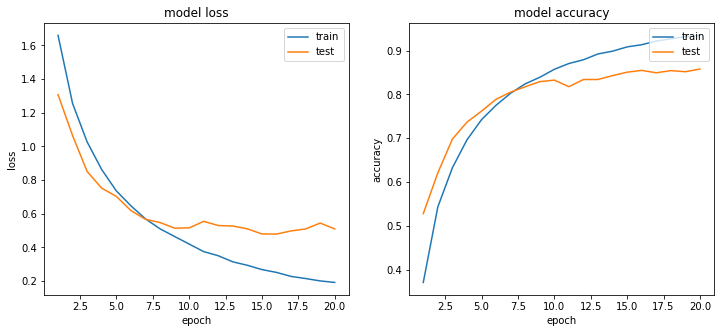

In [7]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

epochs = range(1, EPOCHS + 1)
ax1.plot(epochs, train_epoch_loss)
ax1.plot(epochs, test_epoch_loss)
ax2.plot(epochs, train_epoch_acc)
ax2.plot(epochs, test_epoch_acc)
ax1.set_title('model loss')
ax2.set_title('model accuracy')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc="upper right")
ax2.legend(['train', 'test'], loc="upper right")
plt.show()

### Simplified Adam
A simplified Adam algorithm is described below (discussed in the lecture): \
$\eta$: Step size \
$N_1, N_2$ are typically 100 and 1000 \
$L(\phi)$: Loss function with parameters $\phi$ \
$t$: Current step \
$g_t \gets \nabla_{\phi}f_t(\phi_{t-1})$  (gradients with respect to parameters $\phi$)\
$m_t \gets (1-\frac{1}{min(t, N_1)}) m_{t−1} + \frac{1}{min(t, N_1)} g_t$ (first moment)\
$v_t \gets (1 - \frac{1}{min(t, N_2)}) v_{t-1} + \frac{1}{min(t, N_1)} g_t^2$ (second moment) \

$\phi_{t+1} \gets \phi_t - \frac{\eta m_t}{\sqrt{v_t} + ϵ} $ \


In [13]:
# A simplified adam (taken from lecture notes)
import math
from torch.optim import Optimizer

class AdamSimplified(Optimizer):

    def __init__(self, params, lr=1e-2, betas=(0.9, 0.999), epsilon=1e-8,
            weight_decay=0):
        ns = (1/(1-betas[0]), 1/(1-betas[1]))
        defaults = dict(lr=lr, ns=ns, epsilon=epsilon,
                weight_decay=weight_decay)
        super(AdamSimplified, self).__init__(params, defaults)

    def step(self, forward_closure=None):
        loss = None
        if forward_closure is not None:
            loss = self._forward_backward(forward_closure)

        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad
                state = self.state[id(p)]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = grad.new().resize_as_(grad).zero_()
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = grad.new().resize_as_(grad).zero_()

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                ns1, ns2 = group['ns']

                state['step'] += 1
                t = state['step']

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(1 - 1 / min(t, ns1)).add_(1 / min(t, ns1), grad)
                exp_avg_sq.mul_(1 - 1 / min(t, ns2)).addcmul_(1 / min(t, ns2), grad, grad)

                denom = exp_avg_sq.sqrt().add_(group['epsilon'])              
                step_size = group['lr']
                p.data.addcdiv_(-step_size, exp_avg, denom)

        return loss


In [14]:
import time

EPOCHS = 20
start = time.time()
criterion = torch.nn.CrossEntropyLoss()
model = ResNet().cuda()
lr = 1e-3
optimizer = AdamSimplified(model.parameters(), lr=lr)
train_epoch_loss, test_epoch_loss, train_epoch_acc, test_epoch_acc = train(EPOCHS, model, criterion, optimizer, train_loader, test_loader)
print('time taken: ',time.time() - start)

Epoch 000/020, Train Accuracy 29.76% || Test Accuracy 46.17% || Train Loss 1.82 || Test Loss 1.42
Epoch 001/020, Train Accuracy 47.44% || Test Accuracy 56.77% || Train Loss 1.41 || Test Loss 1.21
Epoch 002/020, Train Accuracy 59.23% || Test Accuracy 65.47% || Train Loss 1.13 || Test Loss 0.99
Epoch 003/020, Train Accuracy 66.14% || Test Accuracy 71.31% || Train Loss 0.96 || Test Loss 0.82
Epoch 004/020, Train Accuracy 70.90% || Test Accuracy 74.88% || Train Loss 0.84 || Test Loss 0.74
Epoch 005/020, Train Accuracy 74.71% || Test Accuracy 76.70% || Train Loss 0.73 || Test Loss 0.69
Epoch 006/020, Train Accuracy 77.92% || Test Accuracy 78.79% || Train Loss 0.65 || Test Loss 0.62
Epoch 007/020, Train Accuracy 80.13% || Test Accuracy 80.61% || Train Loss 0.58 || Test Loss 0.57
Epoch 008/020, Train Accuracy 81.99% || Test Accuracy 80.51% || Train Loss 0.53 || Test Loss 0.58
Epoch 009/020, Train Accuracy 83.46% || Test Accuracy 80.96% || Train Loss 0.48 || Test Loss 0.58
Epoch 010/020, Train

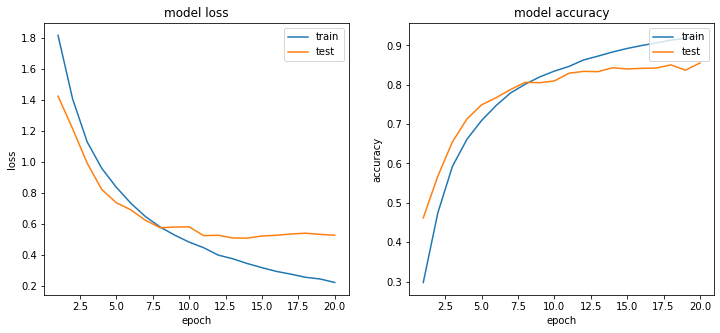

In [15]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

epochs = range(1, EPOCHS + 1)
ax1.plot(epochs, train_epoch_loss)
ax1.plot(epochs, test_epoch_loss)
ax2.plot(epochs, train_epoch_acc)
ax2.plot(epochs, test_epoch_acc)
ax1.set_title('model loss')
ax2.set_title('model accuracy')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc="upper right")
ax2.legend(['train', 'test'], loc="upper right")
plt.show()

### Adam with higher order moment
Adam with higher order moment is described below: \
$\eta$: Step size \
$\beta_1, \beta_2 \in [0, 1)$: Exponential decay rates for the moment estimates \
$L(\phi)$: Loss function with parameters $\phi$ \
$t$: Current step \
$g_t \gets \nabla_{\phi}f_t(\phi_{t-1})$  (gradients with respect to parameters $\phi$)\
$m_t \gets \frac{\beta_1 m_{t−1} + (1 − \beta_1) g_t}{1-\beta_1^t}$ (first moment)\
$v_t \gets \frac{\beta_2 v_{t−1} + (1 − \beta_2) g_t^3}{1 - \beta_2^k}$ (third moment) \

$\phi_{t+1} \gets \phi_t - \frac{\eta m_t}{\sqrt[k]{v_t} + ϵ} $ \


In [32]:
# Adam optimizer
import math
from torch.optim import Optimizer

class Adam_HigherOrderMoment(Optimizer):

    def __init__(self, params, lr=1e-2, betas=(0.9, 0.999), epsilon=1e-8,
            weight_decay=0, order=3):
        defaults = dict(lr=lr, betas=betas, epsilon=epsilon,
                weight_decay=weight_decay, order=order)
        super(Adam_HigherOrderMoment, self).__init__(params, defaults)

    def step(self, forward_closure=None):
        loss = None
        if forward_closure is not None:
            loss = self._forward_backward(forward_closure)

        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad
                state = self.state[id(p)]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = grad.new().resize_as_(grad).zero_()
                    # Exponential moving average of higher order gradient values
                    state['exp_avg_hi'] = grad.new().resize_as_(grad).zero_()

                exp_avg, exp_avg_hi = state['exp_avg'], state['exp_avg_hi']
                beta1, beta2 = group['betas']
                order = group['order']
                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                
                # take power of grad
                grad_pow = grad
                for _ in range(order - 1):
                  grad_pow = grad_pow.mul(grad)
                  

                exp_avg_hi.mul_(beta2).add_(1 - beta2, grad_pow)

                denom = exp_avg_hi.pow(1/order).add_(group['epsilon'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.pow(bias_correction2, 1/order) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom)

        return loss

In [10]:
# order 3
import time

EPOCHS = 20
start = time.time()
criterion = torch.nn.CrossEntropyLoss()
model = ResNet().cuda()
lr = 1e-3
optimizer = Adam_HigherOrderMoment(model.parameters(), lr=lr)
train_epoch_loss, test_epoch_loss, train_epoch_acc, test_epoch_acc = train(EPOCHS, model, criterion, optimizer, train_loader, test_loader)
print('time taken: ',time.time() - start)

Epoch 000/020, Train Accuracy 30.60% || Test Accuracy 47.91% || Train Loss 1.89 || Test Loss 1.41
Epoch 001/020, Train Accuracy 49.94% || Test Accuracy 59.56% || Train Loss 1.37 || Test Loss 1.12
Epoch 002/020, Train Accuracy 60.61% || Test Accuracy 66.67% || Train Loss 1.10 || Test Loss 0.94
Epoch 003/020, Train Accuracy 67.76% || Test Accuracy 73.22% || Train Loss 0.92 || Test Loss 0.79
Epoch 004/020, Train Accuracy 72.37% || Test Accuracy 76.58% || Train Loss 0.79 || Test Loss 0.68
Epoch 005/020, Train Accuracy 75.86% || Test Accuracy 78.56% || Train Loss 0.70 || Test Loss 0.62
Epoch 006/020, Train Accuracy 78.14% || Test Accuracy 80.48% || Train Loss 0.63 || Test Loss 0.59
Epoch 007/020, Train Accuracy 80.14% || Test Accuracy 81.27% || Train Loss 0.58 || Test Loss 0.57
Epoch 008/020, Train Accuracy 81.53% || Test Accuracy 82.52% || Train Loss 0.54 || Test Loss 0.53
Epoch 009/020, Train Accuracy 83.05% || Test Accuracy 81.83% || Train Loss 0.50 || Test Loss 0.54
Epoch 010/020, Train

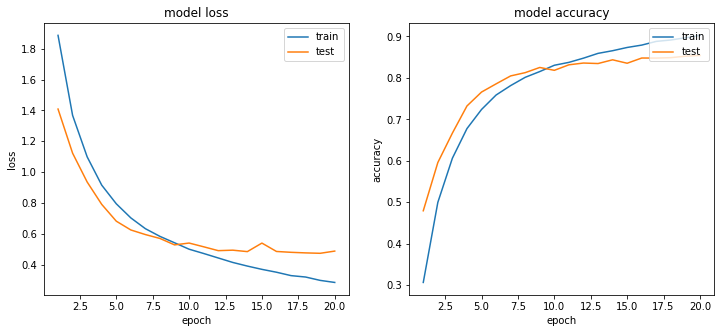

In [13]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

epochs = range(1, EPOCHS + 1)
ax1.plot(epochs, train_epoch_loss)
ax1.plot(epochs, test_epoch_loss)
ax2.plot(epochs, train_epoch_acc)
ax2.plot(epochs, test_epoch_acc)
ax1.set_title('model loss')
ax2.set_title('model accuracy')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc="upper right")
ax2.legend(['train', 'test'], loc="upper right")
plt.show()

In [33]:
# order 4
import time

EPOCHS = 20
start = time.time()
criterion = torch.nn.CrossEntropyLoss()
model = ResNet().cuda()
lr = 1e-3
optimizer = Adam_HigherOrderMoment(model.parameters(), lr=lr, order=4)
train_epoch_loss, test_epoch_loss, train_epoch_acc, test_epoch_acc = train(EPOCHS, model, criterion, optimizer, train_loader, test_loader)
print('time taken: ',time.time() - start)

Epoch 000/020, Train Accuracy 38.47% || Test Accuracy 56.14% || Train Loss 1.65 || Test Loss 1.20
Epoch 001/020, Train Accuracy 58.08% || Test Accuracy 67.10% || Train Loss 1.16 || Test Loss 0.93
Epoch 002/020, Train Accuracy 67.25% || Test Accuracy 73.35% || Train Loss 0.92 || Test Loss 0.76
Epoch 003/020, Train Accuracy 73.05% || Test Accuracy 76.98% || Train Loss 0.78 || Test Loss 0.67
Epoch 004/020, Train Accuracy 77.12% || Test Accuracy 80.63% || Train Loss 0.66 || Test Loss 0.57
Epoch 005/020, Train Accuracy 79.94% || Test Accuracy 81.33% || Train Loss 0.58 || Test Loss 0.55
Epoch 006/020, Train Accuracy 82.34% || Test Accuracy 82.38% || Train Loss 0.51 || Test Loss 0.52
Epoch 007/020, Train Accuracy 84.26% || Test Accuracy 84.06% || Train Loss 0.46 || Test Loss 0.49
Epoch 008/020, Train Accuracy 85.69% || Test Accuracy 84.63% || Train Loss 0.41 || Test Loss 0.47
Epoch 009/020, Train Accuracy 87.18% || Test Accuracy 84.23% || Train Loss 0.37 || Test Loss 0.48
Epoch 010/020, Train

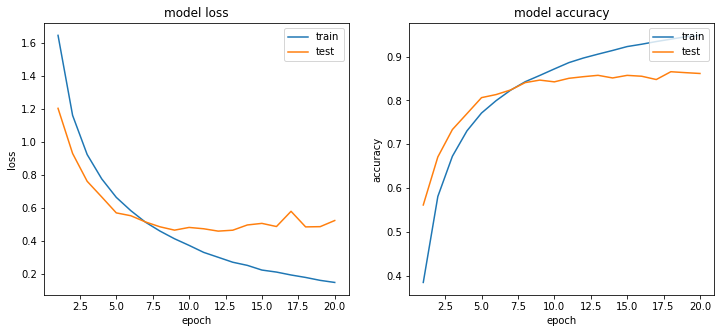

In [34]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

epochs = range(1, EPOCHS + 1)
ax1.plot(epochs, train_epoch_loss)
ax1.plot(epochs, test_epoch_loss)
ax2.plot(epochs, train_epoch_acc)
ax2.plot(epochs, test_epoch_acc)
ax1.set_title('model loss')
ax2.set_title('model accuracy')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc="upper right")
ax2.legend(['train', 'test'], loc="upper right")
plt.show()

In [35]:
# order 5
import time

EPOCHS = 20
start = time.time()
criterion = torch.nn.CrossEntropyLoss()
model = ResNet().cuda()
lr = 1e-3
optimizer = Adam_HigherOrderMoment(model.parameters(), lr=lr, order=5)
train_epoch_loss, test_epoch_loss, train_epoch_acc, test_epoch_acc = train(EPOCHS, model, criterion, optimizer, train_loader, test_loader)
print('time taken: ',time.time() - start)

Epoch 000/020, Train Accuracy 10.00% || Test Accuracy 10.00% || Train Loss nan || Test Loss nan
Epoch 001/020, Train Accuracy 10.00% || Test Accuracy 10.00% || Train Loss nan || Test Loss nan
Epoch 002/020, Train Accuracy 10.00% || Test Accuracy 10.00% || Train Loss nan || Test Loss nan
Epoch 003/020, Train Accuracy 10.00% || Test Accuracy 10.00% || Train Loss nan || Test Loss nan
Epoch 004/020, Train Accuracy 10.00% || Test Accuracy 10.00% || Train Loss nan || Test Loss nan
Epoch 005/020, Train Accuracy 10.00% || Test Accuracy 10.00% || Train Loss nan || Test Loss nan
Epoch 006/020, Train Accuracy 10.00% || Test Accuracy 10.00% || Train Loss nan || Test Loss nan
Epoch 007/020, Train Accuracy 10.00% || Test Accuracy 10.00% || Train Loss nan || Test Loss nan
Epoch 008/020, Train Accuracy 10.00% || Test Accuracy 10.00% || Train Loss nan || Test Loss nan
Epoch 009/020, Train Accuracy 10.00% || Test Accuracy 10.00% || Train Loss nan || Test Loss nan
Epoch 010/020, Train Accuracy 10.00% || 

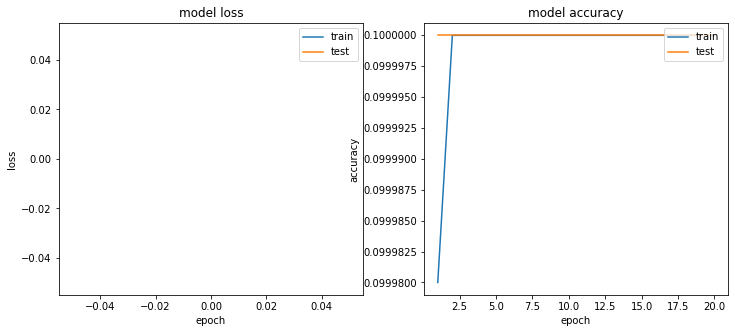

In [36]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

epochs = range(1, EPOCHS + 1)
ax1.plot(epochs, train_epoch_loss)
ax1.plot(epochs, test_epoch_loss)
ax2.plot(epochs, train_epoch_acc)
ax2.plot(epochs, test_epoch_acc)
ax1.set_title('model loss')
ax2.set_title('model accuracy')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc="upper right")
ax2.legend(['train', 'test'], loc="upper right")
plt.show()

### Adam without first moment correction
A modified Adam algorithm without first moment correction is described below: \
$\eta$: Step size \
$\beta_1, \beta_2 \in [0, 1)$: Exponential decay rates for the moment estimates \
$L(\phi)$: Loss function with parameters $\phi$ \
$t$: Current step \
$g_t \gets \nabla_{\phi}f_t(\phi_{t-1})$  (gradients with respect to parameters $\phi$)\
$m_t \gets \beta_1 m_{t−1} + (1 − \beta_1) g_t$ (first moment)\
$v_t \gets \frac{\beta_2 v_{t−1} + (1 − \beta_2) g_t^2}{1 - \beta_2^t}$ (second moment) \

$\phi_{t+1} \gets \phi_t - \frac{\eta m_t}{\sqrt{v_t} + ϵ} $ \


In [24]:
# Adam optimizer without first moment correction
import math
from torch.optim import Optimizer

class Adam_WithoutFirstCorrection(Optimizer):

    def __init__(self, params, lr=1e-2, betas=(0.9, 0.999), epsilon=1e-8,
            weight_decay=0):
        defaults = dict(lr=lr, betas=betas, epsilon=epsilon,
                weight_decay=weight_decay)
        super(Adam_WithoutFirstCorrection, self).__init__(params, defaults)

    def step(self, forward_closure=None):
        loss = None
        if forward_closure is not None:
            loss = self._forward_backward(forward_closure)

        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad
                state = self.state[id(p)]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = grad.new().resize_as_(grad).zero_()
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = grad.new().resize_as_(grad).zero_()

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                denom = exp_avg_sq.sqrt().add_(group['epsilon'])

                # bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2)

                p.data.addcdiv_(-step_size, exp_avg, denom)

        return loss


In [25]:
import time

EPOCHS = 20
start = time.time()
criterion = torch.nn.CrossEntropyLoss()
model = ResNet().cuda()
lr = 1e-3
optimizer = Adam_WithoutFirstCorrection(model.parameters(), lr=lr)
train_epoch_loss, test_epoch_loss, train_epoch_acc, test_epoch_acc = train(EPOCHS, model, criterion, optimizer, train_loader, test_loader)
print('time taken: ',time.time() - start)

Epoch 000/020, Train Accuracy 42.80% || Test Accuracy 57.13% || Train Loss 1.53 || Test Loss 1.20
Epoch 001/020, Train Accuracy 57.47% || Test Accuracy 66.53% || Train Loss 1.18 || Test Loss 0.94
Epoch 002/020, Train Accuracy 67.31% || Test Accuracy 72.97% || Train Loss 0.92 || Test Loss 0.77
Epoch 003/020, Train Accuracy 73.13% || Test Accuracy 76.72% || Train Loss 0.77 || Test Loss 0.68
Epoch 004/020, Train Accuracy 77.25% || Test Accuracy 79.18% || Train Loss 0.66 || Test Loss 0.60
Epoch 005/020, Train Accuracy 79.80% || Test Accuracy 81.06% || Train Loss 0.58 || Test Loss 0.56
Epoch 006/020, Train Accuracy 82.22% || Test Accuracy 82.46% || Train Loss 0.51 || Test Loss 0.53
Epoch 007/020, Train Accuracy 84.28% || Test Accuracy 83.20% || Train Loss 0.46 || Test Loss 0.50
Epoch 008/020, Train Accuracy 85.85% || Test Accuracy 83.11% || Train Loss 0.41 || Test Loss 0.52
Epoch 009/020, Train Accuracy 87.13% || Test Accuracy 83.31% || Train Loss 0.38 || Test Loss 0.50
Epoch 010/020, Train

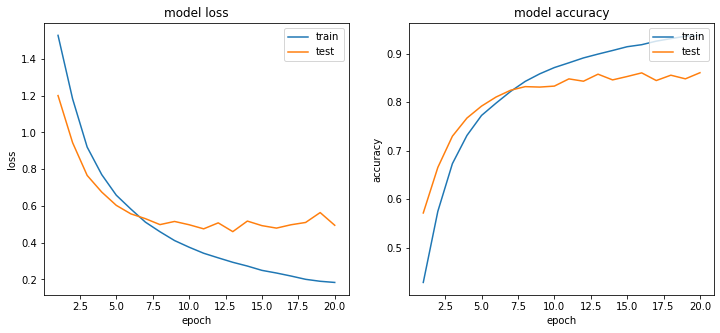

In [27]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

epochs = range(1, EPOCHS + 1)
ax1.plot(epochs, train_epoch_loss)
ax1.plot(epochs, test_epoch_loss)
ax2.plot(epochs, train_epoch_acc)
ax2.plot(epochs, test_epoch_acc)
ax1.set_title('model loss')
ax2.set_title('model accuracy')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc="upper right")
ax2.legend(['train', 'test'], loc="upper right")
plt.show()

### Adam without second moment correction
$\eta$: Step size \
$\beta_1, \beta_2 \in [0, 1)$: Exponential decay rates for the moment estimates \
$L(\phi)$: Loss function with parameters $\phi$ \
$t$: Current step \
$g_t \gets \nabla_{\phi}f_t(\phi_{t-1})$  (gradients with respect to paramters $\phi$)\
$m_t \gets \frac{\beta_1 m_{t−1} + (1 − \beta_1) g_t}{1-\beta_1^t}$ (first moment)\
$v_t \gets \beta_2 v_{t−1} + (1 − \beta_2) g_t^2$ (second moment) \

$\phi_{t+1} \gets \phi_t - \frac{\eta m_t}{\sqrt{v_t} + ϵ} $ \


In [19]:
# Adam optimizer without second moment correction
import math
from torch.optim import Optimizer

class Adam_WithoutSecondCorrection(Optimizer):

    def __init__(self, params, lr=1e-2, betas=(0.9, 0.999), epsilon=1e-8,
            weight_decay=0):
        defaults = dict(lr=lr, betas=betas, epsilon=epsilon,
                weight_decay=weight_decay)
        super(Adam_WithoutSecondCorrection, self).__init__(params, defaults)

    def step(self, forward_closure=None):
        loss = None
        if forward_closure is not None:
            loss = self._forward_backward(forward_closure)

        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad
                state = self.state[id(p)]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = grad.new().resize_as_(grad).zero_()
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = grad.new().resize_as_(grad).zero_()

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                denom = exp_avg_sq.sqrt().add_(group['epsilon'])

                bias_correction1 = 1 - beta1 ** state['step']
                # bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] / bias_correction1 # second correction does not change value by much

                p.data.addcdiv_(-step_size, exp_avg, denom)

        return loss


In [20]:
import time

EPOCHS = 20
start = time.time()
criterion = torch.nn.CrossEntropyLoss()
model = ResNet().cuda()
lr = 1e-3
optimizer = Adam_WithoutSecondCorrection(model.parameters(), lr=lr)
train_epoch_loss, test_epoch_loss, train_epoch_acc, test_epoch_acc = train(EPOCHS, model, criterion, optimizer, train_loader, test_loader)
print('time taken: ',time.time() - start)

Epoch 000/020, Train Accuracy 11.62% || Test Accuracy 17.46% || Train Loss 2.66 || Test Loss 2.13
Epoch 001/020, Train Accuracy 21.17% || Test Accuracy 24.15% || Train Loss 2.01 || Test Loss 1.92
Epoch 002/020, Train Accuracy 25.88% || Test Accuracy 27.44% || Train Loss 1.87 || Test Loss 1.81
Epoch 003/020, Train Accuracy 31.35% || Test Accuracy 33.95% || Train Loss 1.78 || Test Loss 1.71
Epoch 004/020, Train Accuracy 37.22% || Test Accuracy 41.79% || Train Loss 1.65 || Test Loss 1.52
Epoch 005/020, Train Accuracy 42.94% || Test Accuracy 46.42% || Train Loss 1.51 || Test Loss 1.42
Epoch 006/020, Train Accuracy 47.83% || Test Accuracy 51.85% || Train Loss 1.40 || Test Loss 1.29
Epoch 007/020, Train Accuracy 52.46% || Test Accuracy 56.95% || Train Loss 1.29 || Test Loss 1.17
Epoch 008/020, Train Accuracy 56.82% || Test Accuracy 60.66% || Train Loss 1.18 || Test Loss 1.09
Epoch 009/020, Train Accuracy 60.57% || Test Accuracy 63.63% || Train Loss 1.10 || Test Loss 1.02
Epoch 010/020, Train

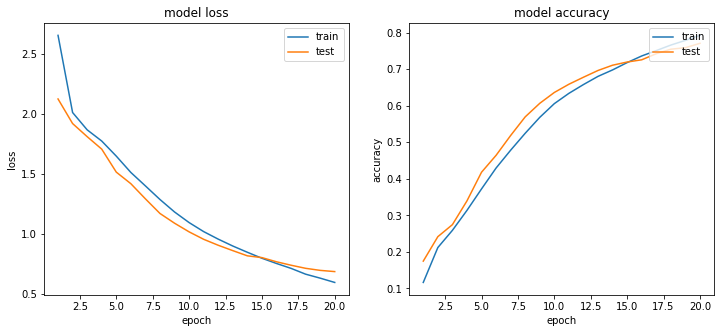

In [22]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

epochs = range(1, EPOCHS + 1)
ax1.plot(epochs, train_epoch_loss)
ax1.plot(epochs, test_epoch_loss)
ax2.plot(epochs, train_epoch_acc)
ax2.plot(epochs, test_epoch_acc)
ax1.set_title('model loss')
ax2.set_title('model accuracy')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc="upper right")
ax2.legend(['train', 'test'], loc="upper right")
plt.show()

### Adam without correction
$\eta$: Step size \
$\beta_1, \beta_2 \in [0, 1)$: Exponential decay rates for the moment estimates \
$L(\phi)$: Loss function with parameters $\phi$ \
$t$: Current step \
$g_t \gets \nabla_{\phi}f_t(\phi_{t-1})$  (gradients with respect to parameters $\phi$)\
$m_t \gets \beta_1 m_{t−1} + (1 − \beta_1) g_t$ (first moment)\
$v_t \gets \beta_2 v_{t−1} + (1 − \beta_2) g_t^2$ (second moment) \

$\phi_{t+1} \gets \phi_t - \frac{\eta m_t}{\sqrt{v_t} + ϵ} $ \


In [28]:
# Adam optimizer without correction
import math
from torch.optim import Optimizer

class Adam_WithoutCorrection(Optimizer):

    def __init__(self, params, lr=1e-2, betas=(0.9, 0.999), epsilon=1e-8,
            weight_decay=0):
        defaults = dict(lr=lr, betas=betas, epsilon=epsilon,
                weight_decay=weight_decay)
        super(Adam_WithoutCorrection, self).__init__(params, defaults)

    def step(self, forward_closure=None):
        loss = None
        if forward_closure is not None:
            loss = self._forward_backward(forward_closure)

        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad
                state = self.state[id(p)]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = grad.new().resize_as_(grad).zero_()
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = grad.new().resize_as_(grad).zero_()

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                denom = exp_avg_sq.sqrt().add_(group['epsilon'])

                # bias_correction1 = 1 - beta1 ** state['step']
                # bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr']

                p.data.addcdiv_(-step_size, exp_avg, denom)

        return loss


In [29]:
import time

EPOCHS = 20
start = time.time()
criterion = torch.nn.CrossEntropyLoss()
model = ResNet().cuda()
lr = 1e-3
optimizer = Adam_WithoutCorrection(model.parameters(), lr=lr)
train_epoch_loss, test_epoch_loss, train_epoch_acc, test_epoch_acc = train(EPOCHS, model, criterion, optimizer, train_loader, test_loader)
print('time taken: ',time.time() - start)

Epoch 000/020, Train Accuracy 15.25% || Test Accuracy 20.29% || Train Loss 2.18 || Test Loss 1.97
Epoch 001/020, Train Accuracy 19.96% || Test Accuracy 20.84% || Train Loss 1.95 || Test Loss 1.89
Epoch 002/020, Train Accuracy 20.82% || Test Accuracy 22.17% || Train Loss 1.89 || Test Loss 1.86
Epoch 003/020, Train Accuracy 21.85% || Test Accuracy 22.40% || Train Loss 1.86 || Test Loss 1.83
Epoch 004/020, Train Accuracy 22.63% || Test Accuracy 23.30% || Train Loss 1.83 || Test Loss 1.79
Epoch 005/020, Train Accuracy 24.16% || Test Accuracy 25.07% || Train Loss 1.80 || Test Loss 1.77
Epoch 006/020, Train Accuracy 26.03% || Test Accuracy 27.18% || Train Loss 1.78 || Test Loss 1.74
Epoch 007/020, Train Accuracy 28.30% || Test Accuracy 29.86% || Train Loss 1.74 || Test Loss 1.71
Epoch 008/020, Train Accuracy 30.11% || Test Accuracy 31.15% || Train Loss 1.72 || Test Loss 1.69
Epoch 009/020, Train Accuracy 32.38% || Test Accuracy 31.11% || Train Loss 1.69 || Test Loss 1.72
Epoch 010/020, Train

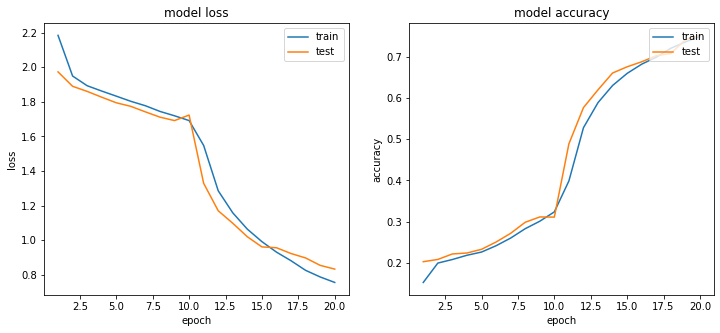

In [30]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

epochs = range(1, EPOCHS + 1)
ax1.plot(epochs, train_epoch_loss)
ax1.plot(epochs, test_epoch_loss)
ax2.plot(epochs, train_epoch_acc)
ax2.plot(epochs, test_epoch_acc)
ax1.set_title('model loss')
ax2.set_title('model accuracy')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc="upper right")
ax2.legend(['train', 'test'], loc="upper right")
plt.show()